# Interactively validate a Convolutional Variational Autoencoder

The code in this nodebook is loading a pre-trained model and experiment with the encoder and decoder. 

In [1]:
import sys
sys.path.append("..")

from settings import Config
sys.path.append(Config().values["conv_vae"]["code_dir"])

from sensorprocessing import sp_conv_vae
from conv_vae import load_image_to_tensor, get_transform

#import torch
#import torchvision.transforms as transforms
#from torchvision import transforms
import os
import matplotlib.pyplot as plt
import pathlib

# Oh, this hack was fixing something, but for me it is the other way around
#temp = pathlib.PosixPath
#pathlib.PosixPath = pathlib.WindowsPath

Loading pointer config file: C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
Loading machine-specific config file: G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml


In [2]:
sp = sp_conv_vae.ConvVaeSensorProcessing()
print(sp.model)
print(sp.model.encoder)
print(f"latent_dim {sp.model.latent_dim}")
# print(model.hidden_dims)

resume_model and jsonfile are:
	resume_model=c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-models\Conv-VAE\models\VAE_Robot\1101_182309\checkpoint-epoch100.pth
	jsonfile=c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-models\Conv-VAE\models\VAE_Robot\1101_182309\config.json
{
    "name": "VAE_Robot",
    "n_gpu": 1,
    "arch": {
        "type": "VanillaVAE",
        "args": {
            "in_channels": 3,
            "latent_dims": 128,
            "flow": false
        }
    },
    "data_loader": {
        "type": "CelebDataLoader",
        "args": {
            "data_dir": "c:\\Users\\lboloni\\Documents\\Code\\_TempData\\BerryPicker-training-data\\robotonly-uncluttered-2024-10-28",
            "batch_size": 64,
            "shuffle": true,
            "validation_split": 0.2,
            "num_workers": 2
        }
    },
    "optimizer": {
        "type": "Adam",
        "args": {
            "lr": 0.005,
            "weight_decay": 0.0,
            "amsgrad": true
   

c:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\encoding_conv_vae\..\sensorprocessing\sp_conv_vae.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.checkp

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

## Pass one picture through the complete autoencoder

Pass one specific picture through the complete autoencoder. Compare the input and the output. This is basically trying out whether the VAE had captured the picture sufficiently.

This code also is intended as a sample of how to use the pre-trained model, how to feed it new data without the training code. 

In [3]:
# picture_name = '../../localdata/img/Rafael.jpg'
# picture_name = '../../localdata/img/indian-man.jpeg'
# picture_name = '../../localdata/img/00029_dev2.jpg'

# Choose a random image from the training data. 

directory = pathlib.Path(Config().values["conv_vae"]["training_data_dir"], "Images")
print(directory)
files = list(directory.glob('*.jpg'))
picture_name = pathlib.Path(directory, files[11])


c:\Users\lboloni\Documents\Code\_TempData\BerryPicker-training-data\robotonly-uncluttered-2024-10-28\Images


torch.Size([3, 64, 64])


mu = tensor([[ 6.5523e-03,  3.4300e-03, -3.8185e-04,  2.5928e-03,  9.7317e-03,
         -4.8917e-03, -1.3490e-03, -3.3855e-03, -7.9335e-03,  2.9991e-03,
          3.7837e-03, -2.9098e-03,  2.2637e-03, -8.9853e-04, -1.1218e-02,
         -1.1654e+00,  1.6420e-03, -1.0337e-02, -1.4951e-03, -4.2250e-04,
          1.0453e-03, -1.7257e-03, -6.2656e-03,  7.6070e-03,  1.3933e-03,
          9.4212e-04, -1.0976e-03, -8.4659e-03,  2.4797e-02, -5.3206e-03,
          3.1977e-03,  9.0443e-03,  5.7513e-03,  5.6178e-03,  1.9781e-03,
          2.5238e-03,  3.7475e-03,  4.5747e-03, -3.5687e-04,  3.2302e-01,
          9.8977e-03,  8.3390e-04, -4.5289e-03,  5.0319e-03, -2.3903e-04,
         -3.5667e-03, -8.4826e-03,  7.6210e-03, -1.4119e-04, -6.1720e-03,
          7.7180e-03, -3.0220e-04, -2.8106e-03,  2.0388e-03, -4.4736e-04,
          3.3655e-03,  2.0298e-03, -4.1423e-03, -8.8997e-04, -1.2220e-02,
         -7.1831e-03,  1.2428e-03,  1.2396e-03,  1.4933e-02, -1.8292e-04,
         -2.9342e-03, -7.6908e-04

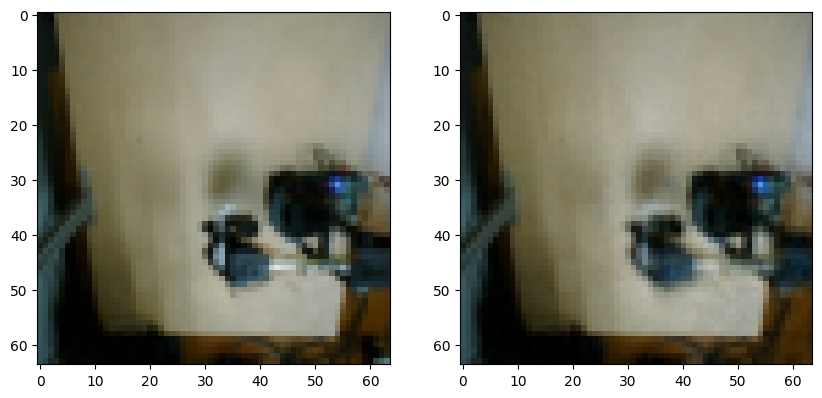

In [4]:
transform = get_transform()

input, image = load_image_to_tensor(picture_name, transform)

# Running the input on the output
output, mu, logvar = sp.model(input)

# Output: the visual reconstruction
output_for_pic = output[0].cpu().permute(1, 2, 0).detach().numpy()

# mu: the encoding,
print(f"mu = {mu}")

# log_var: the log-var values for this input 
print(f"logvar = {logvar}")

# Showing the input and the reconstructed output side by side 
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[1].imshow(output_for_pic)


In [ ]:

# Try to do a decoding from the same mu
z2 = sp.model.reparameterize(mu, logvar)

for i in range(Config().values["robot"]["latent_encoding_size"]):
    z2[0][i] = z2[0][i] + 0.1

#z2[0][1] = 2.0
#z2[0][3] = 2.0
output2 = sp.model.decode(z2)
output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()

# initial and new
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(output_for_pic)
axs[1].imshow(output_for_pic2)


# Generating random samples from the model

In [ ]:
import random

# z2 = model.reparameterize(mu, logvar)
# initial and new
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for x in range(0, 5):
    for y in range(0, 5):
            z2 = sp.model.reparameterize(mu, logvar)
            for i in range(Config().values["robot"]["latent_encoding_size"]):
                z2[0][i] += random.uniform(-0.5, 0.5)
            output2 = sp.model.decode(z2)
            output_for_pic2 = output2[0].cpu().permute(1, 2, 0).detach().numpy()
            axs[x][y].imshow(output_for_pic2)
#axs[0].imshow(output_for_pic)
#axs[1].imshow(output_for_pic2)